In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import warnings
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ds=xr.open_mfdataset(
    '/g/data/oe9/user/rg6346/VI_mask_nc/NDVI/NDVI_????.nc',
    chunks=dict(long=176)) 
ds=ds.rename({'ndvi_evi':'ndvi'})
ds=ds.drop('band')
ds['ndvi']=ds.ndvi/10000;
ds

<xarray.Dataset>
Dimensions:  (lat: 3147, long: 3344, time: 388)
Coordinates:
  * lat      (lat) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * long     (long) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...
  * time     (time) datetime64[ns] 2000-02-18 2000-03-05 2000-03-21 ...
Data variables:
    ndvi     (time, lat, long) float64 dask.array<shape=(388, 3147, 3344), chunksize=(20, 3147, 176)>

## Subset data for testing

In [5]:
sub=ds.sel(lat=slice(-30.1, -31),long=slice(148.9,150.6)) ##yarrie
sub.load()

<xarray.Dataset>
Dimensions:  (lat: 216, long: 408, time: 388)
Coordinates:
  * lat      (lat) float64 -30.1 -30.11 -30.11 -30.11 -30.12 -30.12 -30.13 ...
  * long     (long) float64 148.9 148.9 148.9 148.9 148.9 148.9 148.9 148.9 ...
  * time     (time) datetime64[ns] 2000-02-18 2000-03-05 2000-03-21 ...
Data variables:
    ndvi     (time, lat, long) float64 0.3499 0.3152 0.2693 0.2616 0.2476 ...

In [46]:
ndvi_q=sub.resample(time='Q-FEB').mean(dim='time')
ndvi_jja=ndvi_q.where(ndvi_q['time.season']=='JJA',drop=True)
ndvi_djf=ndvi_q.where(ndvi_q['time.season']=='DJF',drop=True)

/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to

## Linear regression

In [51]:
%%time

latout = []
for lat in ndvi_jja.lat:
    lonout = []
    latout.append(lonout)
    for lon in ndvi_jja.long:
        ndvi = ndvi_jja.sel(lat=lat, long=lon)
        ndvi['days_since'] = (ndvi_jja.time - ndvi_jja.time[0] ).astype(np.float)
        mask = ~np.isinf(ndvi) & ~np.isinf(ndvi.days_since)
        slope, intercept, r_sq, p_values, std_err = stats.linregress(ndvi.days_since[mask],ndvi[mask])
        lonout.append(slope)
arr = np.array(latout)

CPU times: user 13min 46s, sys: 0 ns, total: 13min 46s
Wall time: 13min 45s


In [41]:
%%time

latout = []
for lat in sub.lat:
    lonout = []
    latout.append(lonout)
    for lon in sub.long:
        ndvi = sub.sel(lat=lat, long=lon)
        ndvi['days_since'] = (ndvi.time - ndvi.time[0] ).astype(np.float)
        mask = ~np.isinf(ndvi.ndvi) & ~np.isinf(ndvi.days_since)
        slope, intercept, r_sq, p_values, std_err = stats.linregress(ndvi.days_since[mask],ndvi.ndvi[mask])
        lonout.append(slope)
arr = np.array(latout)


AttributeError: 'DataArray' object has no attribute 'ndvi'

In [52]:
# create new data array
lat=sub.lat
long=sub.long
slope=xr.DataArray(arr,name='slope',dims=('lat','lon'),coords=[lat, long])
slope

<xarray.DataArray 'slope' (lat: 216, lon: 408)>
array([[ 1.096014e-19,  1.032357e-19,  9.535495e-20, ...,  1.633461e-19,
         2.007506e-19,  1.622456e-19],
       [ 2.326123e-19,  3.355335e-19,  2.004910e-19, ...,  2.806077e-19,
         1.924924e-19,  1.927997e-19],
       [ 2.196129e-19,  3.336040e-19,  2.768428e-19, ...,  2.060672e-19,
         2.084617e-19,  2.823169e-19],
       ...,
       [ 8.017822e-20,  7.928075e-20, -8.149629e-20, ...,  3.335563e-19,
         2.861939e-19,  1.791219e-19],
       [-2.650789e-20, -1.120417e-19, -1.176812e-19, ...,  3.564807e-19,
         2.515225e-19,  1.202610e-19],
       [-9.980552e-20, -9.196219e-20, -9.196219e-20, ...,  2.246892e-19,
         2.246892e-19,  1.683842e-19]])
Coordinates:
  * lat      (lat) float64 -30.1 -30.11 -30.11 -30.11 -30.12 -30.12 -30.13 ...
  * lon      (lon) float64 148.9 148.9 148.9 148.9 148.9 148.9 148.9 148.9 ...

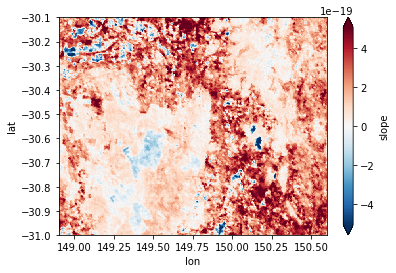

In [53]:
slope.plot.imshow(robust=True)

In [16]:
lat=1
lon=1

ndvi = sub.isel(lat=lat, long=lon)
ndvi['days_since'] = (ndvi.time - ndvi.time[0] ).astype(np.float)
ndvi
mask = ~np.isinf(ndvi.ndvi) & ~np.isinf(ndvi.days_since)
# slope, intercept, r_sq, p_values, std_err = stats.linregress(ndvi.days_since[mask],ndvi[mask])
# lonout.append(slope)

In [1]:

latout = []
for lat in anomalies_NDVI_dt.latitude:
    lonout = []
    latout.append(lonout)
    for lon in anomalies_NDVI_dt.longitude:
        NDVI = anomalies_NDVI_dt.sel(latitude=lat, longitude=lon)
#         SPI = spi_1M_sub.sel(latitude=lat, longitude=lon)
        SPI_1M = spi_sub_dt.sel(latitude=lat, longitude=lon)
        mask = ~np.isinf(SPI_1M)
        subset_NDVI= NDVI.where(mask, drop=True)
        subset_SPI_1M= SPI_1M.where(mask, drop=True)
        
        val = pearsonr(subset_NDVI,subset_SPI_1M)
        try:
            # Spearman's R can fail for some values
            val += spearmanr(NDVI,SPI_1M)
        except ValueError:
            val += (np.nan, np.nan)
        lonout.append(val)
# Then we convert the lists to an array
arr = np.array(latout)
# And finally insert the pieces into our correlation dataset
corr_spi_sub_dt.pearson_r[:] = arr[..., 0]
corr_spi_sub_dt.pearson_p[:] = arr[..., 1]
corr_spi_sub_dt.spearman_r[:] = arr[..., 2]
corr_spi_sub_dt.spearman_p[:] = arr[..., 3]

NameError: name 'sub' is not defined

/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
